In [2]:
import os
import json
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from prepare_data_single_class import coco_to_yolo, select_two_objects

In [3]:
!ls dataset/raw

annotations  annotations_trainval2017.zip  val2017.zip


In [4]:
raw_data_dir = 'dataset/raw'

In [5]:
annotation_dir_path = os.path.join(raw_data_dir, "annotations")
with open(os.path.join(annotation_dir_path, "instances_val2017.json"), "r") as f:
    annotations = json.load(f)

In [6]:
def selectBoxesImages(annotations):
    boxPerImage = defaultdict(list)
    for annotation in annotations["annotations"]:
            boxPerImage[annotation["image_id"]].append(annotation)
    
    tmp = {}
    for k in boxPerImage:
        boxes = select_two_objects(boxPerImage[k])
        if boxes is not None:
            tmp[k] = boxes
            
    
    boxPerImage = tmp
    return boxPerImage

def computeArea(box):
    return box[-1] * box[-2]
    # return np.sqrt(box[-1] * box[-2])
    

In [7]:
boxPerImage = selectBoxesImages(annotations)

In [47]:
all_smallest = np.array([computeArea(k[0]["bbox"]) for k in boxPerImage.values()])
all_largest = np.array([computeArea(k[1]["bbox"]) for k in boxPerImage.values()])

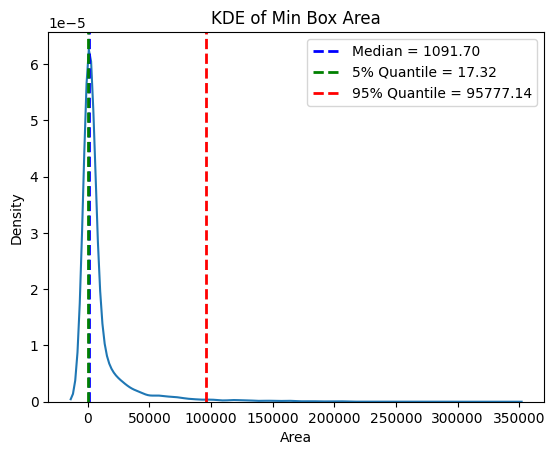

In [70]:
all_smallest, counts = np.unique(all_smallest, return_counts=True)
counts = counts / sum(counts)
# print(all_smallest.shape, counts)

small_quantile_05 = np.quantile(all_smallest,  0.02)
small_quantile_95 = np.quantile(all_smallest, 0.98)
sns.kdeplot(all_smallest)
# plt.axvline(np.mean(all_smallest), color='r', linestyle='dashed', linewidth=2, label=f'Mean = {np.mean(all_smallest):.2f}')
plt.axvline(np.median(all_smallest), color='b', linestyle='dashed', linewidth=2, label=f'Median = {np.median(all_smallest):.2f}')
plt.axvline(small_quantile_05, color='g', linestyle='dashed', linewidth=2, label=f'5% Quantile = {small_quantile_05:.2f}')
plt.axvline(small_quantile_95, color='r', linestyle='dashed', linewidth=2, label=f'95% Quantile = {small_quantile_95:.2f}')
plt.title("KDE of Min Box Area")
plt.xlabel("Area")
plt.legend()
plt.plot()
plt.savefig("KDE_MinBox.png")

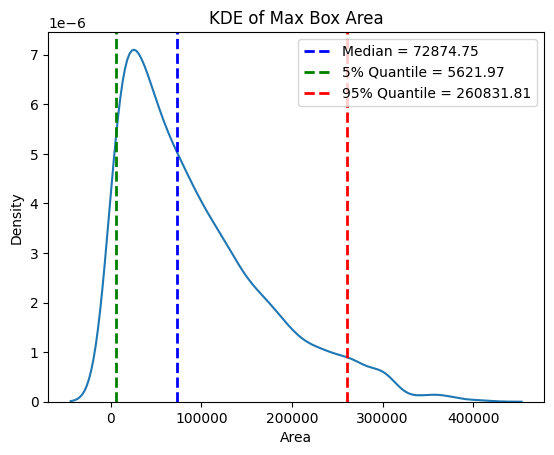

In [49]:
all_largest, counts = np.unique(all_largest, return_counts=True)


large_quantile_05 = np.quantile(all_largest,  0.05)
large_quantile_95 = np.quantile(all_largest, 0.95)
sns.kdeplot(all_largest)
plt.axvline(np.median(all_largest), color='b', linestyle='dashed', linewidth=2, label=f'Median = {np.median(all_largest):.2f}')
plt.axvline(large_quantile_05, color='g', linestyle='dashed', linewidth=2, label=f'5% Quantile = {large_quantile_05:.2f}')
plt.axvline(large_quantile_95, color='r', linestyle='dashed', linewidth=2, label=f'95% Quantile = {large_quantile_95:.2f}')
plt.title("KDE of Max Box Area")
plt.xlabel("Area")
plt.legend()
plt.plot()
plt.savefig("KDE_MaxBox.png")

There is an overlapping between the range of the largest and smalest boxes

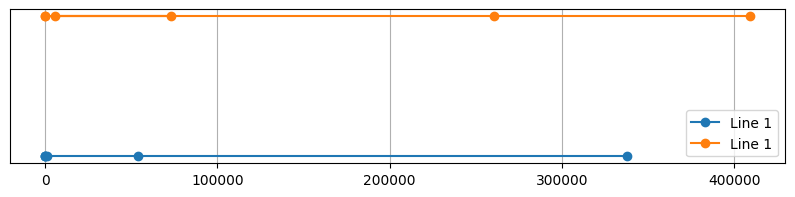

In [59]:
# Create a figure and axis
plt.figure(figsize=(10, 2))

x_smallest = [0, all_smallest.min(), np.median(all_smallest), small_quantile_05, small_quantile_95, all_smallest.max()]
x_largest = [0, all_largest.min(), np.median(all_largest), large_quantile_05, large_quantile_95, all_largest.max()]
x_labels = ["", "min", "max", ]

plt.plot(x_smallest, [0 for _ in x_smallest], label='Line 1', linestyle='-', marker='o')
plt.plot(x_largest, [0.000005 for _ in x_largest], label='Line 1', linestyle='-', marker='o')
for i in [1, -1]:
    


plt.legend()
plt.yticks([])
plt.grid(True)


In [65]:
def draw_overlapping(range1, range2):
    # Determine the overlapping region
    overlap_start = max(range1[0], range2[0])
    overlap_end = min(range1[1], range2[1])

    # Create a figure and axis
    plt.figure(figsize=(8, 2))
    ax = plt.gca()

    # Plot the first range
    plt.barh(0, range1[1] - range1[0], left=range1[0], height=0.2, label='Range 1', color='blue')

    # Plot the second range
    plt.barh(0, range2[1] - range2[0], left=range2[0], height=0.2, label='Range 2', color='orange')

    # Plot the overlapping region
    if overlap_start < overlap_end:
        plt.barh(0, overlap_end - overlap_start, left=overlap_start, height=0.2, label='Overlap', color='green')

    # Set labels and legend
    plt.title("The overlapping region of two ranges of smallest and largest box area")
    plt.xlabel('Area')
    plt.yticks([])
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

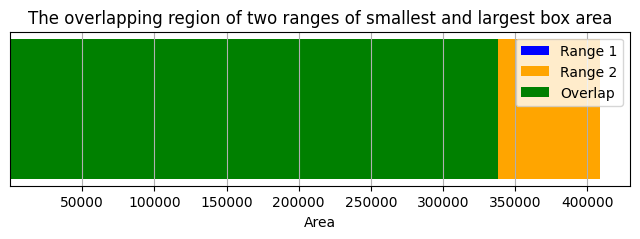

In [66]:
draw_overlapping((all_smallest.min(), all_smallest.max()), 
                 (all_largest.min(), all_largest.max()))

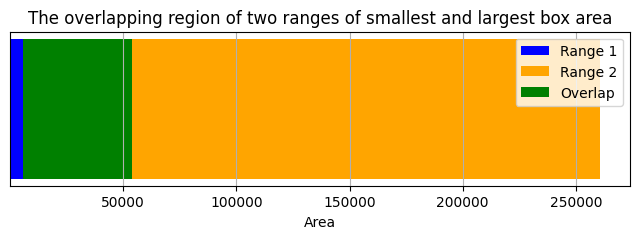

In [67]:
draw_overlapping((small_quantile_05, small_quantile_95), 
                 (large_quantile_05, large_quantile_95))